# Group Equivariant Neural Networks Experiment

### Deep learning and Applied AI exam project.

In this notebook I'm going to test the performance of **Group Equivariant Neural Networks**. I will do a series of tests in two standard datasets :

- Fashion-MNIST
- CIFAR-10

There would be a comparison with standard Convolutioanl Networksl

### 1) Set the environment

We need to download some new libraries.

In [1]:
! pip install numpy scipy matplotlib nose

     |████████████████████████████████| 154 kB 5.2 MB/s 


In [2]:
pip install chainer

     |████████████████████████████████| 1.0 MB 5.3 MB/s 
  Created wheel for chainer: filename=chainer-7.8.0-py3-none-any.whl size=967734 sha256=2a521ff2f9b879dd39527ffee07b557443c9b1e090982fde271d3872db9c90e2
  Stored in directory: /root/.cache/pip/wheels/8d/45/4c/c961846626d4db2511e4acbd5056eefb2aeedcec8208a3ca42
Successfully built chainer


In [3]:
! git clone https://github.com/adambielski/GrouPy.git

Cloning into 'GrouPy'...
remote: Enumerating objects: 167, done.
remote: Total 167 (delta 0), reused 0 (delta 0), pack-reused 167
Receiving objects: 100% (167/167), 141.99 KiB | 1.89 MiB/s, done.
Resolving deltas: 100% (75/75), done.


In [4]:
%cd /content/GrouPy

! ls

/content/GrouPy
groupy	 p4_anim.gif   p4m_fmaps.png  requirements.txt
LICENSE  p4_fmaps.png  README.md      setup.py


In [5]:
! python3 "/content/GrouPy/setup.py" install

running install
running build
running build_py
creating build
creating build/lib
creating build/lib/groupy
copying groupy/__init__.py -> build/lib/groupy
creating build/lib/groupy/garray
copying groupy/garray/test_garray.py -> build/lib/groupy/garray
copying groupy/garray/C4_array.py -> build/lib/groupy/garray
copying groupy/garray/p4m_array.py -> build/lib/groupy/garray
copying groupy/garray/p4_array.py -> build/lib/groupy/garray
copying groupy/garray/Z2_array.py -> build/lib/groupy/garray
copying groupy/garray/garray.py -> build/lib/groupy/garray
copying groupy/garray/finitegroup.py -> build/lib/groupy/garray
copying groupy/garray/__init__.py -> build/lib/groupy/garray
copying groupy/garray/D4_array.py -> build/lib/groupy/garray
copying groupy/garray/matrix_garray.py -> build/lib/groupy/garray
creating build/lib/groupy/gconv
copying groupy/gconv/__init__.py -> build/lib/groupy/gconv
copying groupy/gconv/make_gconv_indices.py -> build/lib/groupy/gconv
creating build/lib/groupy/gconv/c

### 2) Import the libraries

In [6]:
import torch
import numpy as np
import sklearn
import scipy
import pandas as pd
import torch
import matplotlib.pyplot as plt

import torchvision
from typing import *
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from torch.nn import functional as F
from torch.nn import Conv2d
from torch.nn import MaxPool2d as MaxPool2d
from torchvision import datasets, models, transforms

import os

#import the library dedicated to Groups
from groupy.gconv.pytorch_gconv.pooling import plane_group_spatial_max_pooling
from groupy.gconv.pytorch_gconv import P4ConvZ2, P4ConvP4

Turn on the GPU.

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}') 

Using device: cuda:0


### 3) Load the dataset.

In [8]:
# basic transformation
image_transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.RandomRotation(degrees=100),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)


# build the dataloader for trainingset
train_loader = torch.utils.data.DataLoader( datasets.CIFAR10("../prova/data", train=True, 
                            download=True, transform=image_transforms
                            ),
                            batch_size=64,
                            shuffle=True,
                            )


# build the dataloader for testset
test_loader = torch.utils.data.DataLoader( datasets.CIFAR10("../prova/data", train=False,
                            download=True, transform=image_transforms
                            ),
                            batch_size=1000,
                            shuffle=True,
                            )



# build the dataloader for trainingset
train_loader2 = torch.utils.data.DataLoader( datasets.FashionMNIST("../prova/data", train=True, 
                            download=True, transform=image_transforms
                            ),
                            batch_size=64,
                            shuffle=True,
                            )



# build the dataloader for trainingset
test_loader2 = torch.utils.data.DataLoader( datasets.FashionMNIST("../prova/data", train=False, 
                            download=True, transform=image_transforms
                            ),
                            batch_size=1000,
                            shuffle=True,
                            )

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ../prova/data/cifar-10-python.tar.gz to ../prova/data
Files already downloaded and verified


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../prova/data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../prova/data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../prova/data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../prova/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../prova/data/FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [9]:
# Retrieve the image size and the number of color channels for both the dataset
x, _ = next(iter(train_loader))

batch_size = x.shape[0]
n_channels = x.shape[1]
input_size_w = x.shape[2]
input_size_h = x.shape[3]
input_size = input_size_w * input_size_h


dataiter = iter(train_loader)
dataiter2 = iter(train_loader2)
images, labels = dataiter.next()
images2,labels2 = dataiter2.next()

print(images.shape)
print(labels.shape)
print(len(train_loader))

print(images2.shape)
print(labels.shape)
print(len(train_loader))

torch.Size([64, 1, 32, 32])
torch.Size([64])
782
torch.Size([64, 1, 28, 28])
torch.Size([64])
782


### 4) Models

#### Models for CIFAR-10

In [10]:
class GroupCNN(nn.Module):
    
    
    def __init__(self):
        super(GroupCNN, self).__init__()
        self.conv1 = P4ConvZ2(1, 128, kernel_size=3)
        self.conv2 = P4ConvP4(128, 256, kernel_size=3)
        self.conv3 = P4ConvP4(256, 64, kernel_size=3)
        self.conv4 = P4ConvP4(64, 32, kernel_size=3)
        self.fc1 = nn.Linear(3200, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = plane_group_spatial_max_pooling(x, 2)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    
    
class CNN(nn.Module):
    
    
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = Conv2d(1, 256, kernel_size=3, stride=1, padding=0)
        self.conv2 = Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.conv3 = Conv2d(512, 128, kernel_size=3, stride=1, padding=0)
        self.conv4 = Conv2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(1600, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = MaxPool2d(2)(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = MaxPool2d(2)(x)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)
    

#### Models for Fashion-MNIST

In [11]:
class GroupCNN_2(nn.Module):
    
    
    def __init__(self):
        super(GroupCNN_2, self).__init__()
        self.conv1 = P4ConvZ2(1, 128, kernel_size=3)
        self.conv2 = P4ConvP4(128, 256, kernel_size=3)
        self.conv3 = P4ConvP4(256, 64, kernel_size=3)
        self.conv4 = P4ConvP4(64, 32, kernel_size=3)
        self.fc1 = nn.Linear(2048, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = plane_group_spatial_max_pooling(x, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = plane_group_spatial_max_pooling(x, 2)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        #print(x.size())
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)
    
    
    
class CNN_2(nn.Module):
    
    
    def __init__(self):
        super(CNN_2, self).__init__()
        self.conv1 = Conv2d(1, 256, kernel_size=3, stride=1, padding=0)
        self.conv2 = Conv2d(256, 512, kernel_size=3, stride=1, padding=0)
        self.conv3 = Conv2d(512, 128, kernel_size=3, stride=1, padding=0)
        self.conv4 = Conv2d(128, 64, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(1024, 32)
        self.fc2 = nn.Linear(32, 10)


    def forward(self, x):
        
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = MaxPool2d(2)(x)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = MaxPool2d(2)(x)
        
        # now flatten and MLP
        x = x.view(x.size()[0], -1)
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.fc2(x)
        return F.log_softmax(x)

### 5) Trainig Functions

In [12]:
log_freq = len(train_loader)//batch_size * 8

# SOME UTILITY FUNCTION IN ORDER TO MAKE MORE ORGANIZED THE CODE
def train(epoch, loader , net, optimizer, loss_func, log_freq=log_freq):
    
    running_loss = 0.0
    correct = 0
    total = 0
    losses = []
    
    for i, data in enumerate(loader, start=1):
        
        # get the inputs and load into GPU if available
        x, labels = data
        x, labels = x.to(device), labels.to(device)


        # zero the parameter gradients
        optimizer.zero_grad()
        

        # forward + backward + optimize
        outputs = net(x)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        
        #get predications
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        

        # print statistics every log_freq mini batch
        running_loss += loss.item()
        if (i) % log_freq == 0:    # print every log_freq mini batches
            print('[Epoch : %d, Iter: %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / log_freq))
            losses.append( running_loss / log_freq)
            running_loss = 0.0
            print('Top1 Accuracy of the network on the trainset images:', correct / total)
            correct=0
            total=0   
            
    return losses


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



def test(net, loader, train_data=False):
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        
        net.eval()
        
        for batch_idx, data in enumerate(loader):
            
            if batch_idx == len(loader):
                break
            
            #load into GPU if available
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # predict
            output = net(inputs)
            _, predicted = torch.max(output, 1)
            c = (predicted == labels).squeeze().sum().item()
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
        
        print('Accuracy of the network on the testset images:', correct / total)

### G-CNN on CIFAR-10

In [ ]:
epochs = 30
learning_rate = 0.001
loss_func = nn.CrossEntropyLoss()



#construct the models + optimizer
model1 = GroupCNN()
print(model1)
print("number of parameters : ", count_parameters(model1))


if torch.cuda.is_available():
    model1.cuda()

optimizer = optim.Adam(model1.parameters(), lr=learning_rate)
loss_value = []


GroupCNN(
  (conv1): P4ConvZ2()
  (conv2): P4ConvP4()
  (conv3): P4ConvP4()
  (conv4): P4ConvP4()
  (fc1): Linear(in_features=3200, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1947594


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 2.300
Top1 Accuracy of the network on the trainset images: 0.13330078125
[Epoch : 1, Iter:   192] loss: 2.224
Top1 Accuracy of the network on the trainset images: 0.18733723958333334
[Epoch : 1, Iter:   288] loss: 2.156
Top1 Accuracy of the network on the trainset images: 0.22216796875
[Epoch : 1, Iter:   384] loss: 2.096
Top1 Accuracy of the network on the trainset images: 0.2412109375
[Epoch : 1, Iter:   480] loss: 2.024
Top1 Accuracy of the network on the trainset images: 0.26953125
[Epoch : 1, Iter:   576] loss: 1.971
Top1 Accuracy of the network on the trainset images: 0.2941080729166667
[Epoch : 1, Iter:   672] loss: 1.939
Top1 Accuracy of the network on the trainset images: 0.3045247395833333
[Epoch : 1, Iter:   768] loss: 1.918
Top1 Accuracy of the network on the trainset images: 0.3082682291666667
[Epoch : 2, Iter:    96] loss: 1.852
Top1 Accuracy of the network on the trainset images: 0.3370768229166667
[Epoch : 2, Iter:   192] loss: 1.796
Top1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.6201


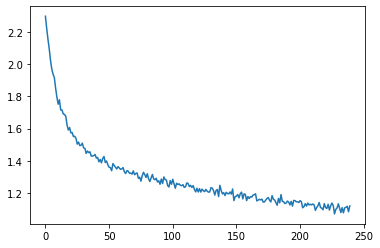

In [ ]:
# training
model1.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader, net=model1, optimizer=optimizer, loss_func=loss_func)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
    

plt.plot(x,  y_ax)

#testing
test(model1, test_loader)

torch.save(model1.state_dict(), "../prova/model1.pt" )

### CNN on CIFAR-10

In [ ]:
epochs = 30
learning_rate = 0.001
loss_func2 = nn.CrossEntropyLoss()

#same paramters of previous model

#construct the models + optimizer
model2 = CNN()
print(model2)
print("number of parameters : ", count_parameters(model2))


if torch.cuda.is_available():
    model2.cuda()

optimizer2 = optim.Adam(model2.parameters(), lr=learning_rate)
loss_value = []


CNN(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1600, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1898026


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:59: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 2.268
Top1 Accuracy of the network on the trainset images: 0.15071614583333334
[Epoch : 1, Iter:   192] loss: 2.188
Top1 Accuracy of the network on the trainset images: 0.20149739583333334
[Epoch : 1, Iter:   288] loss: 2.105
Top1 Accuracy of the network on the trainset images: 0.23876953125
[Epoch : 1, Iter:   384] loss: 2.073
Top1 Accuracy of the network on the trainset images: 0.24446614583333334
[Epoch : 1, Iter:   480] loss: 1.991
Top1 Accuracy of the network on the trainset images: 0.2840169270833333
[Epoch : 1, Iter:   576] loss: 1.982
Top1 Accuracy of the network on the trainset images: 0.2825520833333333
[Epoch : 1, Iter:   672] loss: 1.982
Top1 Accuracy of the network on the trainset images: 0.2781575520833333
[Epoch : 1, Iter:   768] loss: 1.943
Top1 Accuracy of the network on the trainset images: 0.2823893229166667
[Epoch : 2, Iter:    96] loss: 1.916
Top1 Accuracy of the network on the trainset images: 0.30224609375
[Epoch : 2, Iter:   192] l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.6251


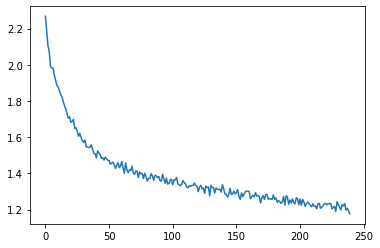

In [ ]:
# training
model2.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader, net=model2, optimizer=optimizer2, loss_func=loss_func2)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))

plt.plot(x,  y_ax)

#testing
test(model1, test_loader)

torch.save(model1.state_dict(), "../prova/model2.pt" )

### G-CNN on Fashion-MNIST

In [13]:
epochs = 30
learning_rate = 0.001
loss_func3 = nn.CrossEntropyLoss()



#construct the models + optimizer
model_mnist = GroupCNN_2()
print(model_mnist)
print("number of parameters : ", count_parameters(model_mnist))


if torch.cuda.is_available():
    model_mnist.cuda()

optimizer3 = optim.Adam(model_mnist.parameters(), lr=learning_rate)
loss_value = []

GroupCNN_2(
  (conv1): P4ConvZ2()
  (conv2): P4ConvP4()
  (conv3): P4ConvP4()
  (conv4): P4ConvP4()
  (fc1): Linear(in_features=2048, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1910730


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 1.825
Top1 Accuracy of the network on the trainset images: 0.3147786458333333
[Epoch : 1, Iter:   192] loss: 1.250
Top1 Accuracy of the network on the trainset images: 0.5358072916666666
[Epoch : 1, Iter:   288] loss: 1.076
Top1 Accuracy of the network on the trainset images: 0.60107421875
[Epoch : 1, Iter:   384] loss: 0.975
Top1 Accuracy of the network on the trainset images: 0.64599609375
[Epoch : 1, Iter:   480] loss: 0.899
Top1 Accuracy of the network on the trainset images: 0.6666666666666666
[Epoch : 1, Iter:   576] loss: 0.875
Top1 Accuracy of the network on the trainset images: 0.6805013020833334
[Epoch : 1, Iter:   672] loss: 0.841
Top1 Accuracy of the network on the trainset images: 0.68896484375
[Epoch : 1, Iter:   768] loss: 0.799
Top1 Accuracy of the network on the trainset images: 0.7083333333333334
[Epoch : 1, Iter:   864] loss: 0.789
Top1 Accuracy of the network on the trainset images: 0.70849609375
[Epoch : 2, Iter:    96] loss: 0.716
To

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.8733


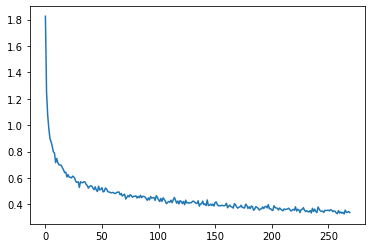

In [14]:
# training
model_mnist.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader2, net=model_mnist, optimizer=optimizer3, loss_func=loss_func3)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
    

plt.plot(x,  y_ax)

#testing
test(model_mnist, test_loader2)

torch.save(model_mnist.state_dict(), "../prova/model_mnist.pt" )

### CNN on Fashion-MNIST

In [15]:
epochs = 30
learning_rate = 0.001
loss_func4 = nn.CrossEntropyLoss()



#construct the models + optimizer
model_mnist2 = CNN_2()
print(model_mnist2)
print("number of parameters : ", count_parameters(model_mnist2))


if torch.cuda.is_available():
    model_mnist2.cuda()

optimizer4 = optim.Adam(model_mnist2.parameters(), lr=learning_rate)
loss_value = []

CNN_2(
  (conv1): Conv2d(1, 256, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(512, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)
number of parameters :  1879594


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[Epoch : 1, Iter:    96] loss: 1.822
Top1 Accuracy of the network on the trainset images: 0.3264973958333333
[Epoch : 1, Iter:   192] loss: 1.342
Top1 Accuracy of the network on the trainset images: 0.5084635416666666
[Epoch : 1, Iter:   288] loss: 1.111
Top1 Accuracy of the network on the trainset images: 0.5861002604166666
[Epoch : 1, Iter:   384] loss: 1.035
Top1 Accuracy of the network on the trainset images: 0.62109375
[Epoch : 1, Iter:   480] loss: 0.985
Top1 Accuracy of the network on the trainset images: 0.6306966145833334
[Epoch : 1, Iter:   576] loss: 0.982
Top1 Accuracy of the network on the trainset images: 0.63232421875
[Epoch : 1, Iter:   672] loss: 0.909
Top1 Accuracy of the network on the trainset images: 0.66064453125
[Epoch : 1, Iter:   768] loss: 0.890
Top1 Accuracy of the network on the trainset images: 0.6608072916666666
[Epoch : 1, Iter:   864] loss: 0.850
Top1 Accuracy of the network on the trainset images: 0.67919921875
[Epoch : 2, Iter:    96] loss: 0.813
Top1 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Accuracy of the network on the testset images: 0.8613


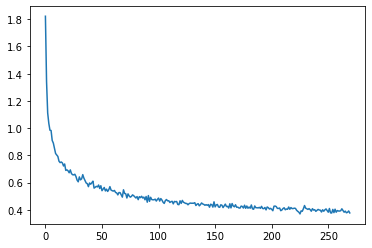

In [16]:
# training
model_mnist2.train()

for i in range(epochs):
    loss_avg = train(epoch=i, loader=train_loader2, net=model_mnist2, optimizer=optimizer4, loss_func=loss_func4)
    loss_value.append(loss_avg)


    
y_ax = np.reshape(loss_value, (-1))
x = range(len(y_ax))
    

plt.plot(x,  y_ax)

#testing
test(model_mnist2, test_loader2)

torch.save(model_mnist2.state_dict(), "../prova/model_mnist2.pt" )